#**Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tensorflow as tf
import nltk
plt.style.use('ggplot')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


#**Importing Data from Kaggle**

In [2]:
# Installing the Kaggle API client
!pip install -q kaggle  # Install the Kaggle package quietly

In [3]:
# Downloading a specific dataset (Amazon reviews) from Kaggle
!kaggle datasets download bittlingmayer/amazonreviews  # Download Amazon reviews dataset from Kaggle

Dataset URL: https://www.kaggle.com/datasets/bittlingmayer/amazonreviews
License(s): unknown
100% 492M/493M [00:03<00:00, 144MB/s]
100% 493M/493M [00:03<00:00, 144MB/s]


In [4]:
# Unzipping the Amazon reviews dataset ZIP file
! unzip amazonreviews.zip

Archive:  amazonreviews.zip
  inflating: test.ft.txt.bz2         
  inflating: train.ft.txt.bz2        


# **Data preparation**


### Train Data

In [5]:
# Reading a bzip2-compressed file as a pandas DataFrame
train_data = pd.read_csv('/content/train.ft.txt.bz2', compression='bz2', delimiter='\t', header=None)

# Displaying the first few rows of the DataFrame to inspect its structure
train_data.head()

,0
0,__label__2 Stuning even for the non-gamer: Thi...
1,__label__2 The best soundtrack ever to anythin...
2,__label__2 Amazing!: This soundtrack is my fav...
3,__label__2 Excellent Soundtrack: I truly like ...
4,"__label__2 Remember, Pull Your Jaw Off The Flo..."


In [6]:
# Taking a random sample of 400,000 rows from the DataFrame
train_sample = train_data.sample(n=400000, random_state=42)  # Sample 400,000 rows with a random seed for reproducibility

# Displaying the sample
train_sample.head()  # Show the first few rows of the random sample

,0
2079998,__label__1 Expensive Junk: This product consis...
1443106,__label__1 Toast too dark: Even on the lowest ...
3463669,__label__2 Excellent imagery...dumbed down sto...
2914699,__label__1 Are we pretending everyone is marri...
1603231,__label__1 Not worth your time: Might as well ...


### Test Data

In [7]:
# Reading a file compressed with bzip2 (.bz2) format as a pandas DataFrame
test_data = pd.read_csv('/content/test.ft.txt.bz2', compression='bz2', delimiter='\t', header=None)

# Displaying the first few rows of the DataFrame to inspect its structure
test_data.head()

,0
0,__label__2 Great CD: My lovely Pat has one of ...
1,__label__2 One of the best game music soundtra...
2,__label__1 Batteries died within a year ...: I...
3,"__label__2 works fine, but Maha Energy is bett..."
4,__label__2 Great for the non-audiophile: Revie...


In [8]:
# Taking a random sample of 100,000 rows from the DataFrame
test_sample = test_data.sample(n=100000, random_state=42)  # Sample 100,000 rows with a random seed for reproducibility

# Displaying the sample
test_sample.head()  # Show the first few rows of the random sample

,0
23218,__label__2 This is a great book: I must prefac...
20731,__label__1 Huge Disappointment.: As a big time...
39555,__label__2 Wayne is tight but cant hang with T...
147506,__label__2 Excellent: I read this book when I ...
314215,__label__1 Not about Anusara: Although this bo...


# **Data preprocessing**

In [9]:
def data_view(file):                   # to  returning a new DataFrame with two columns: label and review
    data = []                                   # empty list for rows of data:label and the corresponding text
    for index, row in file.iterrows():          # iterrows() method for looping on rows(row index , current row)

        line = row[0]                           # first column of the row (ex=> __label__2)

        label, text = line.split(' ', 1)        # label:before first space,text:after the first space =>(first space in parameter 1 )

        label = label.replace('__label__', '')  # removes __label__& leaves num represent label(ex:__label__2 => 2)

        data.append((label, text.strip()))      # label & strip() to remove any space before or after the text

    cols = ['label', 'review']                  # column names(label & review for text)
    return pd.DataFrame(data, columns=cols)     # make data list in a pandas DataFrame

In [10]:
# Applying the data_view function to the sampled DataFrame
train = data_view(train_sample)  # Process the sampled DataFrame using the data_view function

# Displaying the first few rows of the processed DataFrame
train.head()  # Show the first few rows of the processed train DataFrame

,label,review
0,1,Expensive Junk: This product consists of a pie...
1,1,"Toast too dark: Even on the lowest setting, th..."
2,2,Excellent imagery...dumbed down story: I enjoy...
3,1,Are we pretending everyone is married?: The au...
4,1,Not worth your time: Might as well just use a ...


In [11]:
# Applying the data_view function to the second sampled DataFrame
test = data_view(test_sample)  # Process the second sampled DataFrame using the data_view function

# Displaying the first few rows of the processed DataFrame
test.head()  # Show the first few rows of the processed test DataFrame

,label,review
0,2,This is a great book: I must preface this by s...
1,1,"Huge Disappointment.: As a big time, long term..."
2,2,Wayne is tight but cant hang with Turk.: This ...
3,2,Excellent: I read this book when I was in elem...
4,1,Not about Anusara: Although this book is toute...


In [12]:
def preprocess_text(text):
    """
    Preprocesses the input text by converting to lowercase, removing punctuation and digits,
    splitting into words, removing stop words, and applying lemmatization.

    Args:
        text (str): The input text to be preprocessed.

    Returns:
        str: The preprocessed text.
    """
    # Convert the text to lowercase
    text = text.lower()

    # Remove punctuation and digits
    text = re.sub(r'[^\w\s]', '', text).strip()   # Remove punctuation
    text = re.sub(r'\d+', '', text).strip()        # Remove digits

    # Split the text into words
    words = text.split()

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Apply lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

In [13]:
# Cleaning the text by applying the preprocess_text function to each review in the 'review' column
train['review'] = train['review'].apply(preprocess_text)  # Clean the text in the train DataFrame
train.head()

,label,review
0,1,expensive junk product consists piece thin fle...
1,1,toast dark even lowest setting toast dark liki...
2,2,excellent imagerydumbed story enjoyed disc vid...
3,1,pretending everyone married author pretend par...
4,1,worth time might well use knife product hold n...


In [14]:
test['review'] = test['review'].apply(preprocess_text)    # Clean the text in the test DataFrame
test.head()

,label,review
0,2,great book must preface saying religious loved...
1,1,huge disappointment big time long term trevani...
2,2,wayne tight cant hang turk album hot want howe...
3,2,excellent read book elementary school probably...
4,1,anusara although book touted several anusara w...


# **Exploratory Data Analysis (EDA)**

# Visualization

##  1-Statistical Analysis Visualization

       review_length
count  400000.000000
mean      268.582875
std       150.885883
min        17.000000
25%       143.000000
50%       236.000000
75%       370.000000
max       954.000000
       review_length
count  100000.000000
mean      269.598810
std       150.877727
min        18.000000
25%       144.000000
50%       237.000000
75%       372.000000
max       943.000000


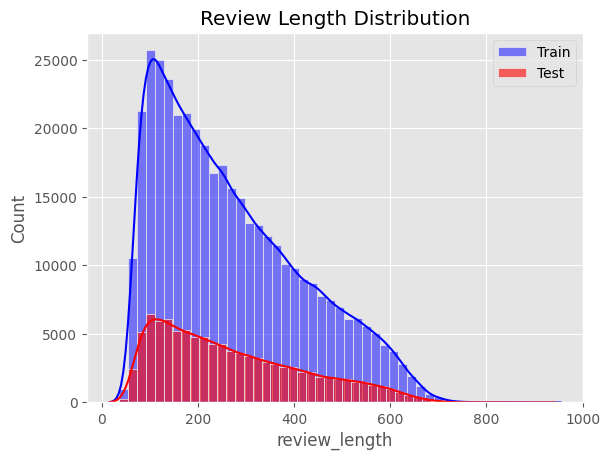

In [15]:
# عرض إحصائيات عامة عن النصوص والأطوال
train['review_length'] = train['review'].apply(len)
test['review_length'] = test['review'].apply(len)

# إحصائيات عامة
print(train[['label', 'review_length']].describe())
print(test[['label', 'review_length']].describe())

# توزيع الأطوال
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(train['review_length'], bins=50, kde=True, color='blue', label='Train')
sns.histplot(test['review_length'], bins=50, kde=True, color='red', label='Test', alpha=0.6)
plt.legend()
plt.title('Review Length Distribution')
plt.show()


Train Label Distribution:
 label
2    200244
1    199756
Name: count, dtype: int64
Test Label Distribution:
 label
1    50013
2    49987
Name: count, dtype: int64


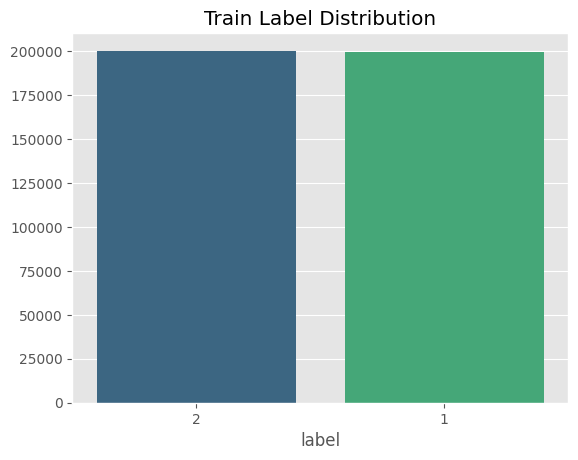

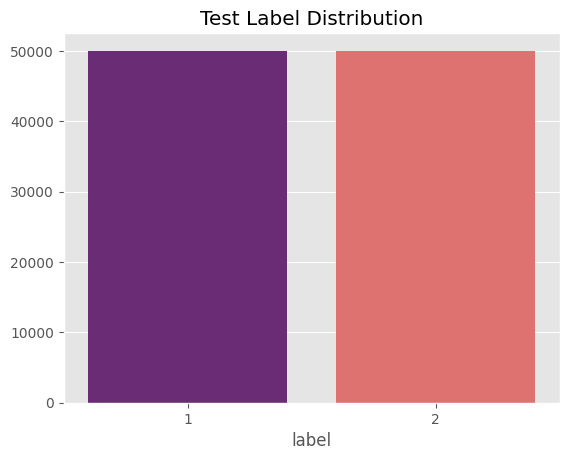

In [16]:
# Calculate the label distribution in the train and test datasets
train_label_distribution = train['label'].value_counts()
test_label_distribution = test['label'].value_counts()

# Print the label distributions
print("Train Label Distribution:\n", train_label_distribution)
print("Test Label Distribution:\n", test_label_distribution)

# Plot the label distribution for the train dataset
sns.barplot(x=train_label_distribution.index, y=train_label_distribution.values, palette="viridis")
plt.title('Train Label Distribution')
plt.show()

# Plot the label distribution for the test dataset
sns.barplot(x=test_label_distribution.index, y=test_label_distribution.values, palette="magma")
plt.title('Test Label Distribution')
plt.show()


In [17]:
# Function to find the most common words in the text
def most_common_words(texts, n=20):
    all_words = ' '.join(texts).split()
    counter = Counter(all_words)
    return counter.most_common(n)

# Most common words in the train dataset
print("Most Common Words in Train Dataset:")
print(most_common_words(train['review']))

# Most common words for each label in the train dataset
for label in train['label'].unique():
    common_words = most_common_words(train[train['label'] == label]['review'])
    print(f"Most Common Words for Label {label}:")
    print(common_words)

Most Common Words in Train Dataset:
[('book', 243947), ('one', 154950), ('great', 117689), ('like', 115706), ('good', 113043), ('would', 93028), ('time', 90236), ('get', 85871), ('read', 77389), ('movie', 75659), ('dont', 69066), ('work', 64693), ('really', 63172), ('love', 59581), ('well', 56709), ('even', 55716), ('much', 55583), ('first', 54793), ('product', 53891), ('make', 52881)]
Most Common Words for Label 1:
[('book', 117918), ('one', 79260), ('like', 60443), ('would', 57506), ('get', 48657), ('time', 48462), ('good', 47463), ('dont', 46390), ('movie', 40189), ('even', 35467), ('work', 34566), ('product', 34535), ('read', 33247), ('buy', 31710), ('much', 31045), ('really', 30892), ('money', 30169), ('first', 28412), ('great', 26451), ('make', 26136)]
Most Common Words for Label 2:
[('book', 126029), ('great', 91238), ('one', 75690), ('good', 65580), ('like', 55263), ('love', 46036), ('read', 44142), ('time', 41774), ('get', 37214), ('would', 35522), ('movie', 35470), ('well', 3

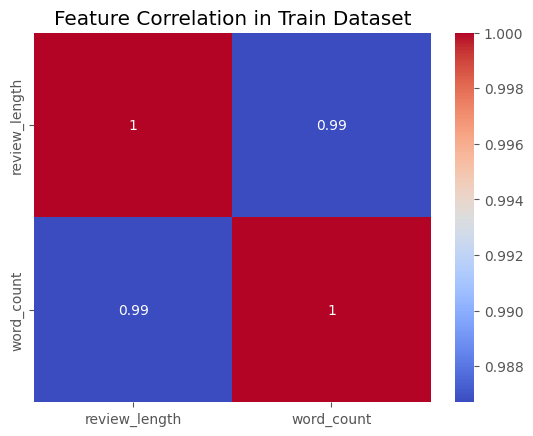

In [18]:
# Create new features: word count and average word length
train['word_count'] = train['review'].apply(lambda x: len(x.split()))
test['word_count'] = test['review'].apply(lambda x: len(x.split()))

# Analyze the relationship between features
sns.heatmap(train[['review_length', 'word_count']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation in Train Dataset')
plt.show()


In [19]:
# Outliers based on review length
long_reviews = train[train['review_length'] > train['review_length'].quantile(0.95)]
short_reviews = train[train['review_length'] < train['review_length'].quantile(0.05)]

# Display long reviews (top 5%)
print("Long Reviews (Top 5%):")
print(long_reviews.head())

# Display short reviews (bottom 5%)
print("Short Reviews (Bottom 5%):")
print(short_reviews.head())


Long Reviews (Top 5%):
   label                                             review  review_length  \
20     2  excelente compilación de lo mejor de caifanes ...            702   
27     2  one best album ive owned year back father got ...            617   
29     1  mac owner beware wife purchased rocket ebook c...            584   
82     1  history morrisville seen eye pedophile guy acc...            650   
88     1  absolute garbage many thing wrong keyboard fir...            617   

    word_count  
20         123  
27          94  
29          86  
82          82  
88          88  
Short Reviews (Bottom 5%):
    label                                             review  review_length  \
4       1  worth time might well use knife product hold n...             79   
26      2  nice ive saved lot space hanging shoe heavier ...             72   
76      2  recorder book granddaughter good reading music...             72   
154     2  coby mp easy operate downloads well saving pla...   

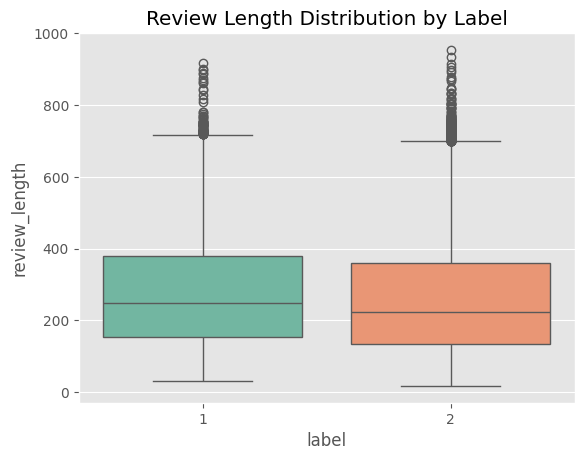

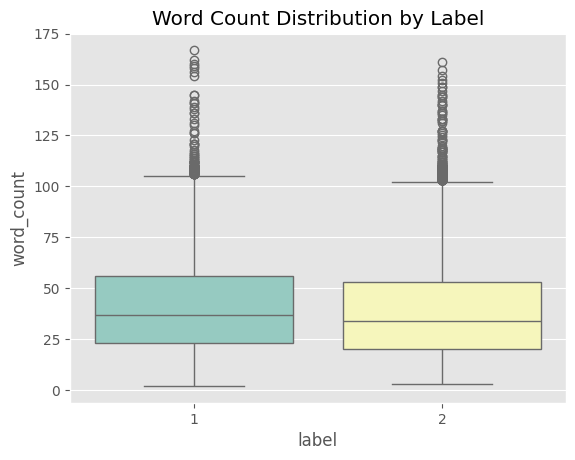

In [20]:
# Plot the distribution of review lengths by label
sns.boxplot(x='label', y='review_length', data=train, palette='Set2')
plt.title('Review Length Distribution by Label')
plt.show()

sns.boxplot(x='label', y='word_count', data=train, palette='Set3')
plt.title('Word Count Distribution by Label')
plt.show()

Train Label Distribution (Percentage):
 label
2    50.061
1    49.939
Name: proportion, dtype: float64
Test Label Distribution (Percentage):
 label
1    50.013
2    49.987
Name: proportion, dtype: float64


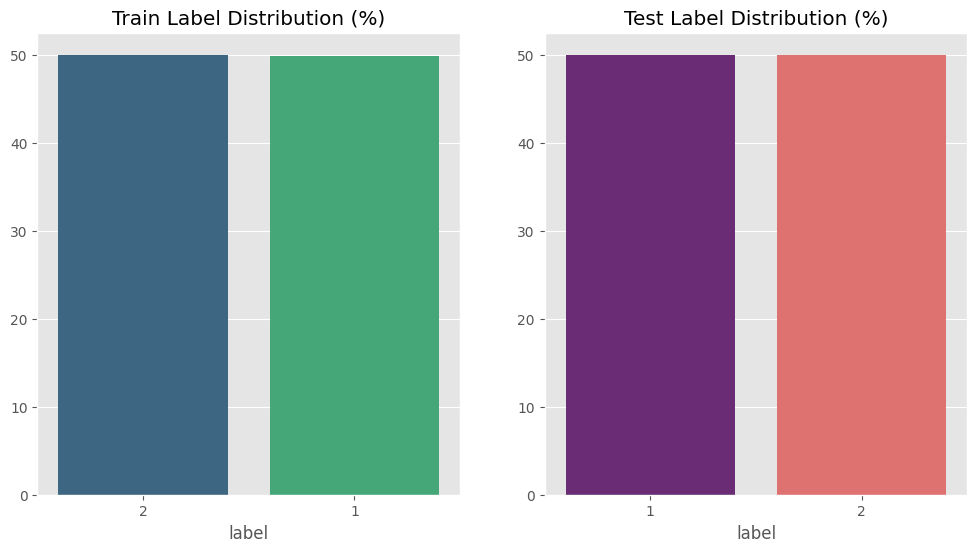

In [21]:
# Calculate the percentage distribution of labels in the train and test datasets
train_label_ratio = train['label'].value_counts(normalize=True) * 100
test_label_ratio = test['label'].value_counts(normalize=True) * 100

# Print the percentage label distributions
print("Train Label Distribution (Percentage):\n", train_label_ratio)
print("Test Label Distribution (Percentage):\n", test_label_ratio)

# Plot the label distribution percentages
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(x=train_label_ratio.index, y=train_label_ratio.values, ax=ax[0], palette='viridis')
ax[0].set_title('Train Label Distribution (%)')
sns.barplot(x=test_label_ratio.index, y=test_label_ratio.values, ax=ax[1], palette='magma')
ax[1].set_title('Test Label Distribution (%)')
plt.show()


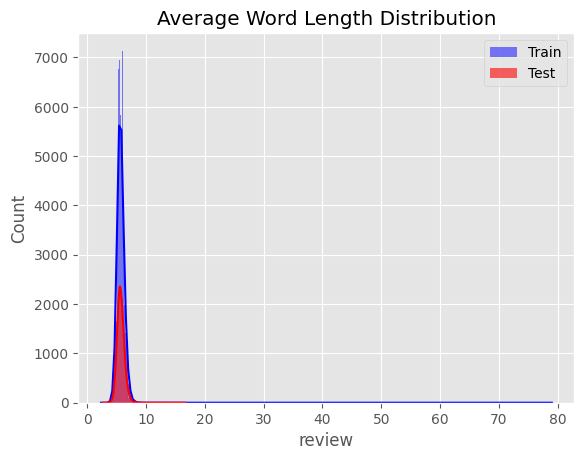

In [22]:
# Plot the distribution of average word length
sns.histplot(train['review'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split())), kde=True, color='blue', label='Train')
sns.histplot(test['review'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split())), kde=True, color='red', label='Test', alpha=0.6)
plt.legend()
plt.title('Average Word Length Distribution')
plt.show()

       review_length  word_count  avg_word_length
label                                            
1         277.053230   41.322609         5.706437
2         260.133163   38.830512         5.691447


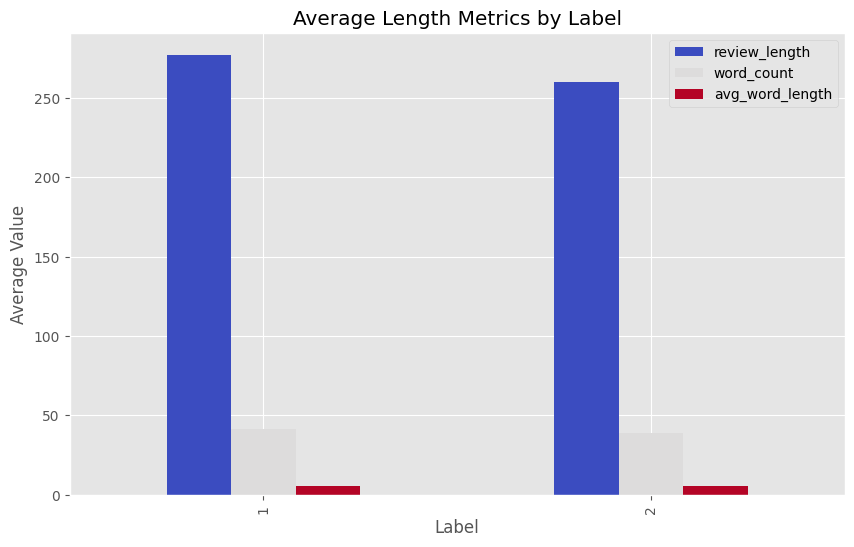

In [23]:
# Group by 'label' and calculate the mean for review_length, word_count, and avg_word_length without adding new columns
length_stats = train.groupby('label').apply(
    lambda x: pd.Series({
        'review_length': x['review'].apply(len).mean(),
        'word_count': x['review'].apply(lambda text: len(text.split())).mean(),
        'avg_word_length': x['review'].apply(lambda text: sum(len(word) for word in text.split()) / len(text.split()) if len(text.split()) > 0 else 0).mean()
    })
)

# Print the calculated statistics
print(length_stats)

# Plot the statistics for each label
length_stats.plot(kind='bar', figsize=(10, 6), colormap='coolwarm')
plt.title('Average Length Metrics by Label')
plt.ylabel('Average Value')
plt.xlabel('Label')
plt.show()


In [24]:
from textblob import TextBlob
# Lets calculate the Polarity of the Reviews
def get_polarity(text):                                         # Fanction produces polarity,
    textblob = TextBlob(str(text.encode('utf-8')))              # polarity expresses how positive or negative the text,
    pol = textblob.sentiment.polarity                           # means -1 with a very negative , 0 neutral, and 1 with a very positive
    return pol
# lets apply the function
train['polarity'] = train['review'].apply(get_polarity)


# Lets calculate the Subjectvity of the Reviews
def get_subjectivity(text):
    textblob = TextBlob(str(text.encode('utf-8')))
    subj = textblob.sentiment.subjectivity
    return subj
# lets apply the Function
train['subjectivity'] = train['review'].apply(get_subjectivity)


# Lets calculate the Polarity of the Reviews
def classify_polarity(polarity):
    if polarity == 0:
        return "Neutral"
    elif 0 < polarity <= 0.3:
        return "Weakly Positive"
    elif 0.3 < polarity <= 0.6:
        return "Positive"
    elif 0.6 < polarity <= 1:
        return "Strongly Positive"
    elif -0.3 < polarity <= 0:
        return "Weakly Negative"
    elif -0.6 < polarity <= -0.3:
        return "Negative"
    elif -1 <= polarity <= -0.6:
        return "Strongly Negative"

train['polarity_strengeth'] = train['polarity'].apply(classify_polarity)


In [25]:
train.sample(10)

,label,review,review_length,word_count,polarity,subjectivity,polarity_strengeth
180583,1,terrible get hoyle casino instead slot poker m...,240,36,-0.260000,0.580000,Weakly Negative
75263,2,great product work great im going serving miss...,134,22,0.566667,0.708333,Positive
167348,1,want money back reading great review wasted ha...,100,15,0.077083,0.322917,Weakly Positive
370467,1,en personally think monitor horrible seemed gr...,180,25,-0.041667,0.697222,Weakly Negative
211756,2,full info poorly written interesting historica...,487,69,0.106944,0.368056,Weakly Positive
52692,1,two reason disappointed item would attractive ...,305,48,0.125000,0.545748,Weakly Positive
186868,2,hard clean rim work fine advertised isnt easil...,369,55,0.113636,0.415909,Weakly Positive
168319,2,another great addition sims honestly say love ...,403,64,0.228030,0.469129,Weakly Positive
120989,2,guy approves wire little stiffer cable im used...,243,39,0.070417,0.377500,Weakly Positive
50961,2,exactly advertised excellent buy half could fo...,95,13,0.270833,0.354167,Weakly Positive


## 2-Public Visualization

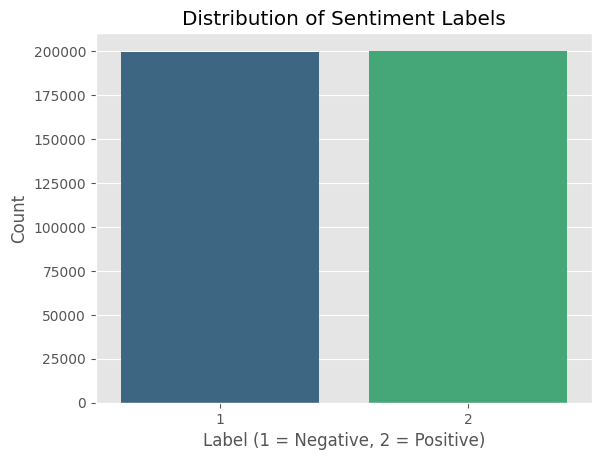

In [26]:
# Create a count plot to visualize the distribution of sentiment labels with updated syntax
sns.countplot(x=train['label'], hue=train['label'], palette="viridis")  # Specify 'hue' to fix the warning

# Set the title of the plot
plt.title("Distribution of Sentiment Labels")

# Set the label for the x-axis to describe the sentiment labels
plt.xlabel("Label (1 = Negative, 2 = Positive)")

# Set the label for the y-axis to describe what the bar heights represent
plt.ylabel("Count")

# Display the plot on the screen
plt.show()

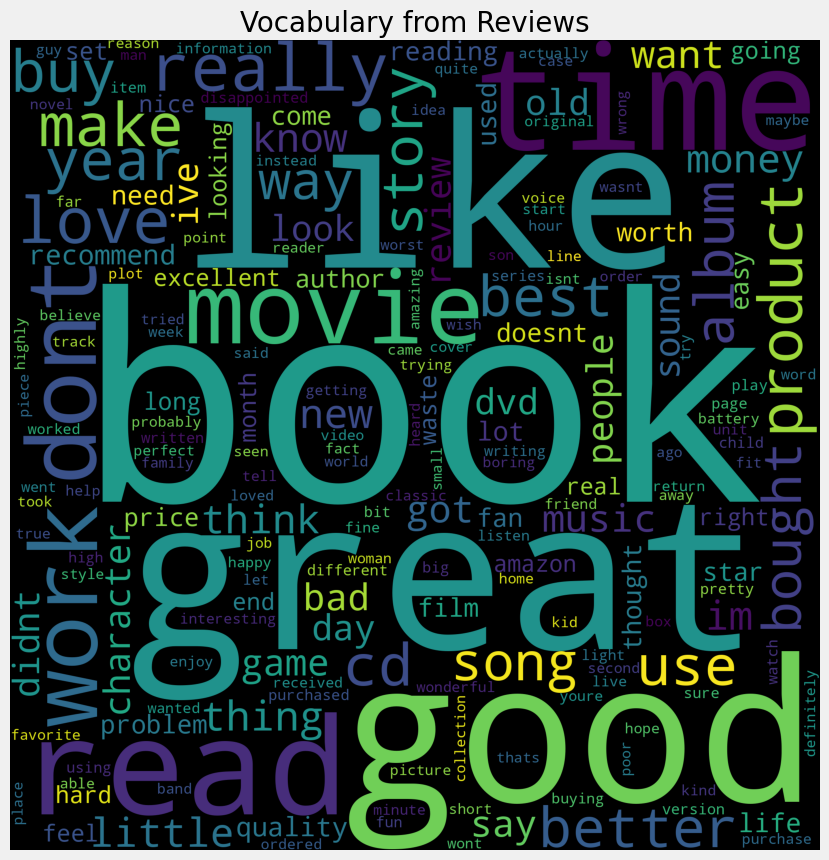

In [27]:
# lets plot the Wordscloud
from wordcloud import WordCloud      # generate word cloud to determine the most frequent words
from sklearn.feature_extraction.text import CountVectorizer  # Convert Text data to words
cv = CountVectorizer(stop_words = 'english')   # Remove stop words that don't have meaning like(a,the,if,...)
words = cv.fit_transform(train.review)
sum_words = words.sum(axis=0)  # Sum number of occurance for each word in the matrix

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]  # بيعمل قايمة فيها كل كلمة وعدد مرات تكرارها
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)  # بترتبهم من الاكتر للأقل

wordcloud = WordCloud(background_color = 'black', width = 2000, height = 2000).generate_from_frequencies(dict(words_freq))  # بيظبط شكل الرسمة

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("Vocabulary from Reviews", fontsize = 20)
plt.show()


#This code is used to generate a word cloud from a collection of text data
#(specifically, the cleaned_reviews in the train_data DataFrame).
#A word cloud is a visual representation of the most frequent words in the text
#where the size of each word corresponds to its frequency. The most frequent words appear larger
#making it easy to identify important or recurring terms.

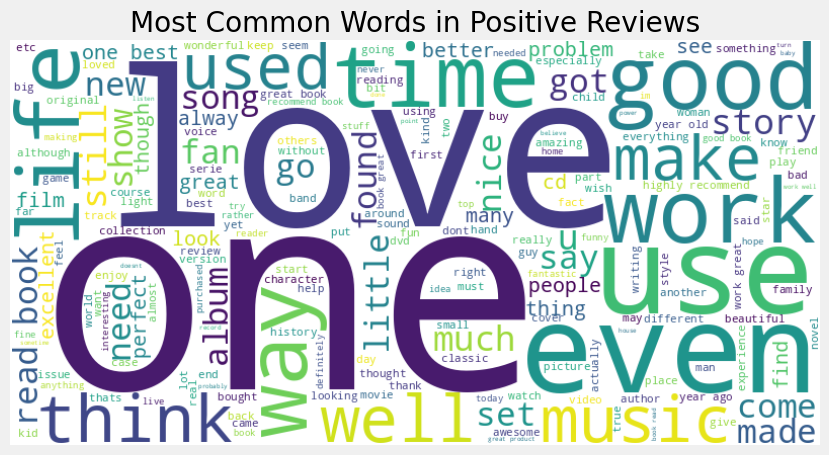

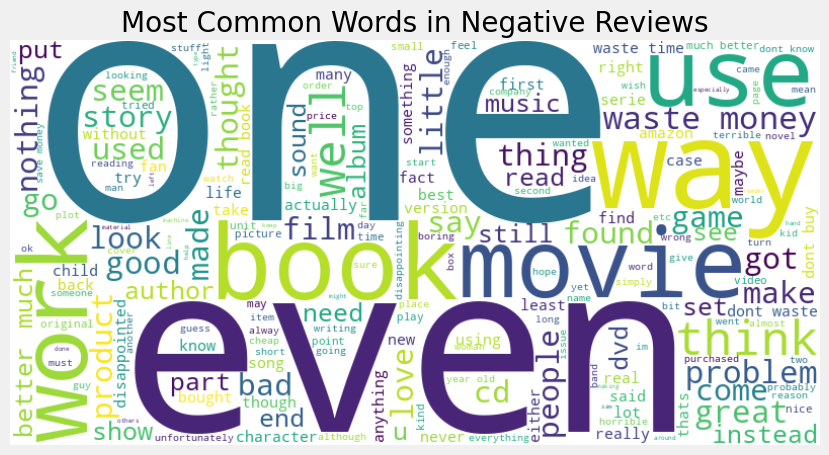

In [28]:
from collections import Counter
from wordcloud import WordCloud

# The most common words in Positive Reviews
positive_reviews = " ".join(train[train['label'] == "2"]['review'])
positive_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(positive_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Positive Reviews")
plt.show()


# The most common words in Negative Reviews
negative_reviews = " ".join(train[train['label'] == "1"]['review'])
negative_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(negative_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Negative Reviews")
plt.show()

#This code is used to generate two separate word clouds: one for positive reviews and one for negative reviews in a dataset.
#A word cloud is a visual representation where the size of each word is proportional to its frequency in the text.
#This helps to identify the most commonly used words in the reviews for each sentiment.

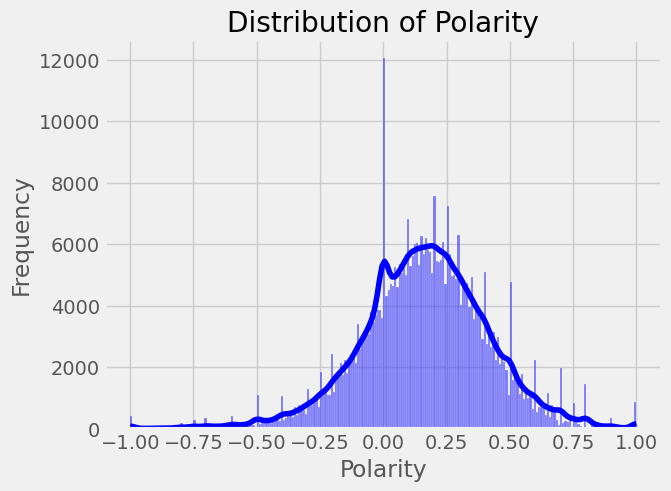

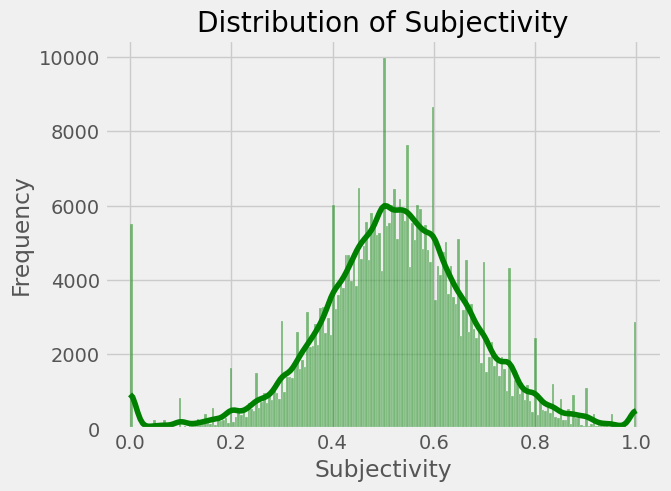

In [29]:
# Distribution of Polarity
sns.histplot(train['polarity'], kde=True, color='blue')
plt.title('Distribution of Polarity')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.show()

# Distribution of Subjectivity
sns.histplot(train['subjectivity'], kde=True, color='green')
plt.title('Distribution of Subjectivity')
plt.xlabel('Subjectivity')
plt.ylabel('Frequency')
plt.show()

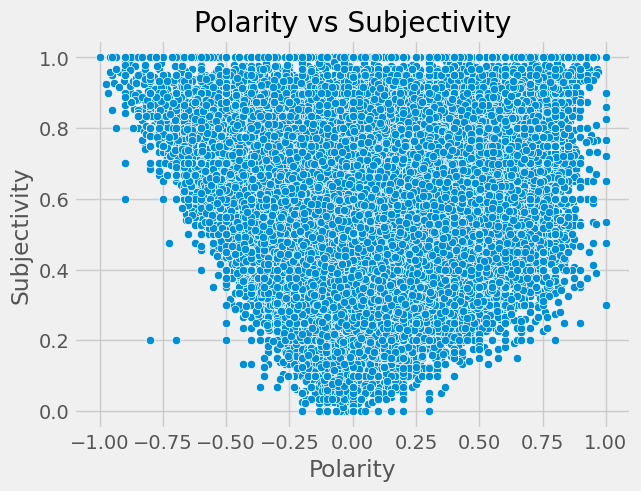

In [30]:
sns.scatterplot(x=train['polarity'], y=train['subjectivity'])
plt.title('Polarity vs Subjectivity')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()
# بيوضح القطبية والذاتية لكل نقطة بس عشان متتخضش

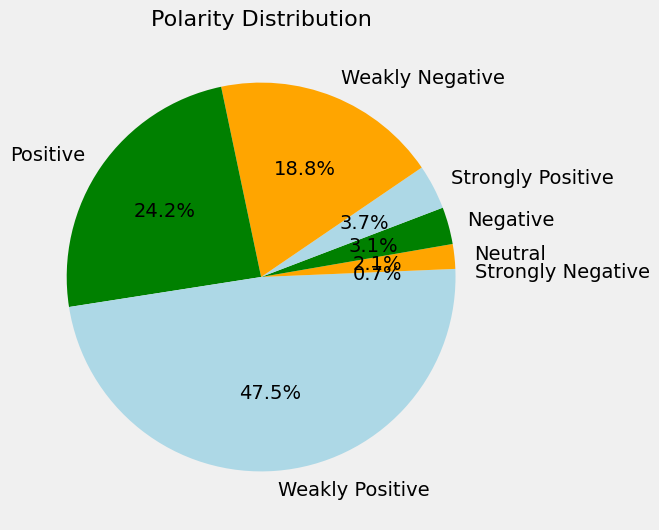

In [31]:
plt.figure(figsize=(8, 6))
train['polarity_strengeth'].value_counts().sort_values().plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'orange', 'green'])
plt.title("Polarity Distribution", fontsize=16)
plt.ylabel('')
plt.show()

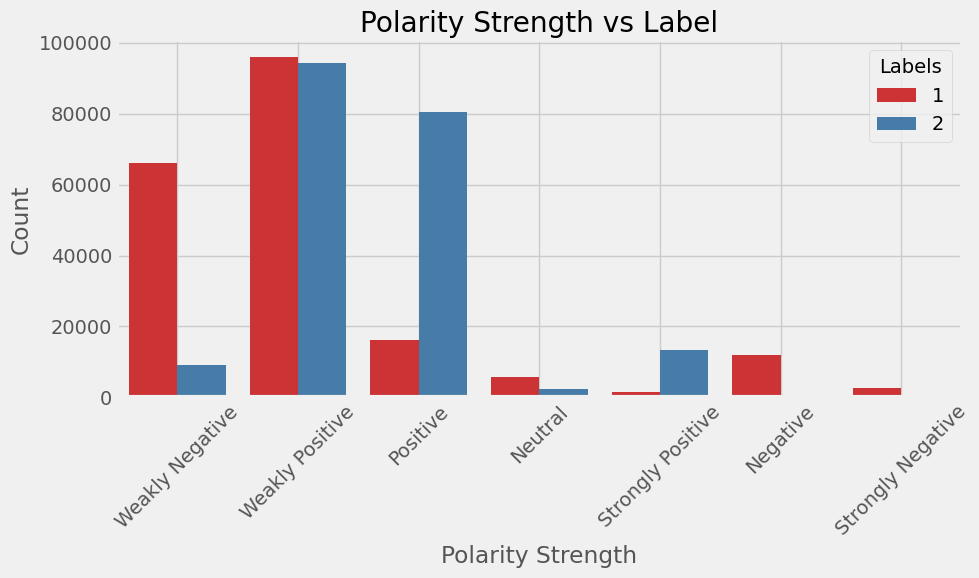

In [32]:
plt.figure(figsize=(10, 6))
sns.countplot(x='polarity_strengeth', hue='label', data=train, palette='Set1')
plt.title('Polarity Strength vs Label')
plt.xlabel('Polarity Strength')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Labels')
plt.tight_layout()
plt.show()

## **Convert Text to Numeric Sequences**


In [33]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Setting parameters for tokenization
max_words = 10000  # Maximum number of words to consider in the tokenizer
max_len = 100      # Maximum length of sequences

# Initializing and fitting the tokenizer on the training data
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")    #Limit the vocabulary size (the number of words)
tokenizer.fit_on_texts(train['review'])        # Fit tokenizer on the reduced training data

# Converting the cleaned texts into numerical sequences
X_train = tokenizer.texts_to_sequences(train['review'])  # Texts to numerical sequences for training
X_test = tokenizer.texts_to_sequences(test['review'])    # Texts to numerical sequences for testing

# Applying padding to the sequences to ensure they all have the same length
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')  # Padding for training sequences
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')    # Padding for testing sequences

# Converting labels to numpy arrays
y_train = train['label'].values  # Training labels
y_test = test['label'].values    # Testing labels

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [35]:
# Convert labels from text ('1' or '2') to integer (0 or 1)
y_train = (y_train.astype(int) - 1).astype(int)  # Convert labels from '1', '2' to binary labels
y_test = (y_test.astype(int) - 1).astype(int)    # Convert labels from '1', '2' to binary labels
y_val = (y_val.astype(int) - 1).astype(int)      # Convert labels from '1', '2' to binary labels

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
# Saving the tokenizer to a file using Pickle
import pickle

# Open a file in write-binary mode to save the tokenizer
with open('/content/drive/My Drive/Colab Notebooks/tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)  # Save the tokenizer object to the file

print("Tokenizer saved successfully!")  # Confirmation message after saving

Tokenizer saved successfully!


# **Build LSTM Model**

In [38]:
from tensorflow.keras.models import Sequential    # Importing Sequential model to stack layers sequentially
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,Input, BatchNormalization    # Importing necessary layers
from tensorflow.keras.optimizers import Adam     # Importing Adam optimizer

# Model configration
vocab_size = max_words    # Define vocabulary size, the maximum number of words in the tokenizer
embedding_dim = 128        # Dimension of word embeddings to represent words as dense vectors
max_len = 100      # Maximum length of input sequences; shorter sequences will be padded, longer truncated

# Building the model
model = Sequential([                   # Initialize the model as a stack of layers
    Input(shape=(max_len,), dtype='int32'),      # Define the input shape as a sequence of integers of length max_len
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),    # Convert words to dense vectors
    LSTM(256, return_sequences=True, dropout=0.3),     # First LSTM layer with 256 units, outputs sequences, adds 30% dropout
    BatchNormalization(),                 # Normalize data to stabilize training and improve learning speed

    LSTM(128, return_sequences=False, dropout=0.3),     # Second LSTM layer with 128 units, outputs only final state
    BatchNormalization(),                 # Normalize data to stabilize and regularize the output

    Dense(128, activation='relu'),      # Fully connected layer with 128 neurons and ReLU activation for learning complex patterns
    Dropout(0.3),      # Apply 30% dropout for regularization to prevent overfitting
    Dense(1, activation='sigmoid')     # Output layer with 1 neuron for binary classification (0 or 1) using sigmoid activation
])


# Compiling the model
optimizer = Adam(learning_rate=0.0001)         # Define Adam optimizer with a low learning rate for better weight updates
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Compile model with binary cross-entropy loss and accuracy metric


In [39]:
# Displaying the model summary
model.summary()  # Display the model architecture

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100, 256)            │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 100, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,889,537 (7.21 MB)

 Trainable params: 1,888,769 (7.21 MB)

 Non-trainable params: 768 (3.00 KB)

# **Train The Model**

In [40]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

# Setting up EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',       # Metric to monitor (you can use 'val_accuracy' if you prefer validation accuracy)
    patience=4,               # Number of epochs without improvement before stopping training
    restore_best_weights=True # Restore the best weights after stopping training
)

# Setting up ModelCheckpoint
save_best_model = ModelCheckpoint(
    '/content/drive/MyDrive/Colab Notebooks/sentiment_model.keras',  # Save path
    monitor='val_loss',  # Monitor the validation loss
    save_best_only=True,  # Save only the best model
    verbose=1  # Show updates in training logs
)



In [41]:
# train the model
history = model.fit(X_train, y_train, batch_size=128,epochs=15, validation_data=(X_val, y_val), callbacks=[early_stopping, save_best_model])


Epoch 1/15
2186/2188 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5006 - loss: 0.7150
Epoch 1: val_loss improved from inf to 0.70174, saving model to /content/drive/MyDrive/Colab Notebooks/sentiment_model.keras
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 81s 33ms/step - accuracy: 0.5006 - loss: 0.7150 - val_accuracy: 0.4994 - val_loss: 0.7017
Epoch 2/15
2187/2188 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4998 - loss: 0.6934
Epoch 2: val_loss improved from 0.70174 to 0.69364, saving model to /content/drive/MyDrive/Colab Notebooks/sentiment_model.keras
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 77s 33ms/step - accuracy: 0.4998 - loss: 0.6934 - val_accuracy: 0.4996 - val_loss: 0.6936
Epoch 3/15
2187/2188 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4994 - loss: 0.6933
Epoch 3: val_loss improved from 0.69364 to 0.69317, saving model to /content/drive/MyDrive/Colab Notebooks/sentiment_model.keras
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 82s 33ms/step - accuracy: 0.4994 - loss: 0.6933 - val_accuracy: 0.5000 - val_

## Evaluate The Model

In [42]:
# Evaluating the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)  # Evaluate the model on the test data

# Printing the test loss and test accuracy
print(f"Test Loss = {test_loss * 100:.2f}%")
print(f"Test Accuracy= {test_accuracy * 100:.2f}%")

y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9014 - loss: 0.2423
Test Loss = 24.38%
Test Accuracy= 90.13%
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     50013
           1       0.90      0.90      0.90     49987

    accuracy                           0.90    100000
   macro avg       0.90      0.90      0.90    100000
weighted avg       0.90      0.90      0.90    100000



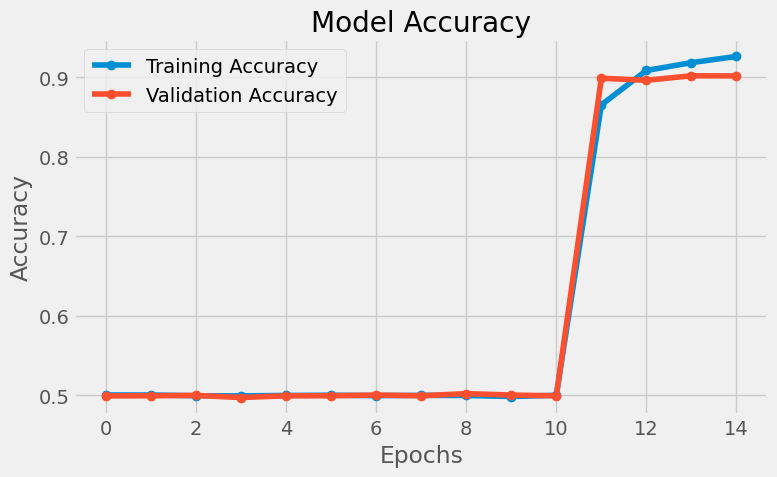

In [43]:
# Accuracy plot
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

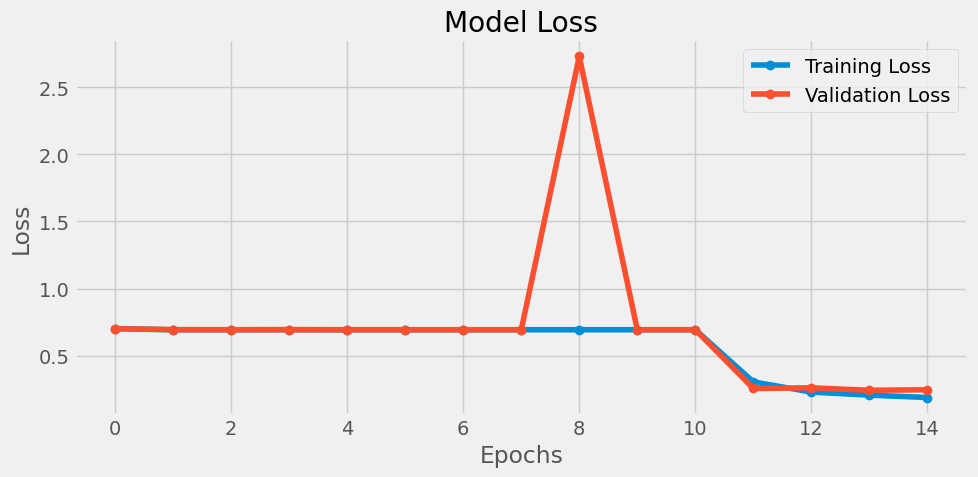

In [44]:
# Loss plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

## Apple model on Real Examples

In [45]:
# Define a function to preprocess the text
def preprocess_text(text, tokenizer, max_len=200):
    sequences = tokenizer.texts_to_sequences([text])       # Convert text to sequences
    padded = pad_sequences(sequences, maxlen=max_len)    # Pad the sequences to ensure consistent input length
    return padded

# Example real text data
real_examples = [
    "This product is amazing and works perfectly!",
    "Terrible product, would not recommend to anyone.",
]

# Preprocess the examples
preprocessed_examples = [preprocess_text(text, tokenizer) for text in real_examples]
# Predict using model
for i, example in enumerate(real_examples):
    preprocessed = preprocess_text(example, tokenizer)
    lstm_pred = model.predict(preprocessed)[0][0]

    lstm_pred_label = 'Positive' if lstm_pred > 0.5 else 'Negative'

    print(f"Example: {example}")
    print(f"LSTM Prediction: {lstm_pred_label} (Probability: {lstm_pred:.4f})")
    print()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
Example: This product is amazing and works perfectly!
LSTM Prediction: Positive (Probability: 0.9651)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Example: Terrible product, would not recommend to anyone.
LSTM Prediction: Negative (Probability: 0.4769)



# **Interface using Streamlit**

In [46]:
!pip install streamlit tensorflow nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 107.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.8 MB/s eta 0:00:00


In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
import shutil

# Source path of the image on the local device after downloading to Google Drive
source_path = "/content/img.jpg"  # Make sure this path is correct

# Destination path inside Google Drive in the 'Colab Notebooks' folder
destination_path = "/content/drive/MyDrive/Colab Notebooks/img.jpg"

# Copy the image to the new location
shutil.copy(source_path, destination_path)

print("The image has been successfully saved to Google Drive!")

FileNotFoundError: [Errno 2] No such file or directory: '/content/img.jpg'

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
%%writefile app.py
import streamlit as st
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import re
import nltk

# Load the pre-trained model and tokenizer
model = load_model("/content/drive/MyDrive/Colab Notebooks/sentiment_model.keras")
with open('/content/drive/MyDrive/Colab Notebooks/tokenizer.pkl', 'rb') as file:
    tokenizer = pickle.load(file)

# Set Streamlit page configuration
st.set_page_config(page_title="Sentiment Analysis", page_icon="💬", layout="wide")

# Default tab to "Home"
if "current_tab" not in st.session_state:
    st.session_state.current_tab = "Home"

# Sidebar navigation
with st.sidebar:
    st.title("Sentiment Analysis")
    st.title("📂")
    if st.button("🔍 Analyze Sentiment"):
        st.session_state.current_tab = "Analyze Sentiment"
    if st.button("📄 Documentation"):
        st.session_state.current_tab = "Documentation"

# Home Tab
if st.session_state.current_tab == "Home":
    st.image(r"/content/drive/MyDrive/Colab Notebooks/img.jpg", use_container_width=True)

    st.markdown("""
    #### Project Overview in Sentiment Analysis 💬:
    This application leverages Deep Learning techniques to analyze text reviews and classify them as (**positive**|**negative**) sentiments.
    It uses an LSTM (Long Short-Term Memory) model that has been trained on a large dataset of text reviews. The application allows users to input a text review which will then be analyzed and classified based on sentiment.

    #### Features:
    - **Text Classification**: Classifies input text as **positive** or **negative** sentiment.
    - **User-Friendly Interface**: Simple text box to input reviews and receive immediate feedback.
    - **Real-time Sentiment Analysis**: Provides feedback based on the model's confidence level.

    #### How It Works:
    - The model processes the input text by tokenizing and padding it to match the format used during training.
    - The processed text is then passed through the LSTM model to predict the sentiment.
    - The result is displayed with a confidence level indicating the certainty of the prediction.

    ### About the Model:
    - **Model Type**: LSTM (Long Short-Term Memory) neural network.
    - **Training Data**: A large dataset of labeled text reviews.
    - **Purpose**: Binary sentiment classification: **positive** or **negative**.

    #### Requirements:
    - Input text should be in English for optimal performance.
    """)

# Analyze Sentiment Tab
elif st.session_state.current_tab == "Analyze Sentiment":
    nltk.download('stopwords')
    nltk.download('wordnet')

    # Model and tokenizer settings
    max_len = 100  # Adjust based on your model

    # Function to preprocess text
    def preprocess_text(text):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        words = text.split()
        stop_words = set(nltk.corpus.stopwords.words('english'))
        words = [word for word in words if word not in stop_words]
        lemmatizer = nltk.WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
        return ' '.join(words)

    # Function to predict sentiment
    def predict_sentiment(text):
        cleaned = preprocess_text(text)
        seq = tokenizer.texts_to_sequences([cleaned])
        padded = pad_sequences(seq, maxlen=max_len, padding='post')
        prediction = model.predict(padded)
        sentiment = "😊 Positive" if prediction[0][0] > 0.5 else "😞 Negative"
        confidence = prediction[0][0]
        return sentiment, confidence

    # Streamlit Interface
    st.title("🔍 Analyze Sentiment")
    st.write("Use the input box below to analyze the sentiment of a text review.")

    input_text = st.text_area("Enter your review:")

    if st.button("Analyze Sentiment"):
        if input_text.strip() == "":
            st.warning("⚠️ Please enter some text to analyze.")
        else:
            sentiment, confidence = predict_sentiment(input_text)
            st.subheader("Analysis Result")
            st.markdown(f"""
            **Sentiment:** {sentiment}
            **Confidence Level:** {confidence:.2f}
            """)
            if confidence > 0.85:
                st.balloons()
            st.progress(int(confidence * 100))

    if st.button("Back to Home"):
        st.session_state.current_tab = "Home"

# Documentation Tab
elif st.session_state.current_tab == "Documentation":
    st.title("📄 Documentation")
    st.write("""
    ## Dataset URL:
    **Amazon Reviews dataset**: Amazon Reviews Dataset The Amazon Reviews dataset contains **3.6 million** reviews with binary sentiment classes: **positive** or **negative**.

    ## Project Goals:
    - **Perform EDA** to uncover insights from the text data.
    - **Preprocess the dataset**, including splitting it into training and testing sets, and transforming the text data into input vectors using techniques such as tokenization or word embeddings.
    - **Develop an LSTM model** using PyTorch or Tensorflow to perform sentiment analysis on the input data.
    - **Experiment with different neural network architectures**, activation functions, and learning rates to optimize the model.
    - **Evaluate the performance** of the model using metrics such as accuracy, precision, recall, and F1 score.
    - **Visualize the results** using confusion matrices or other visualization techniques to assess model performance on different sentiment classes.

    ## Steps:

    ### Data Exploration:
    - Start by downloading the chosen dataset. Familiarize yourself with its structure and content, looking at the distribution of sentiment classes and identifying any anomalies.

    ### Data Preprocessing:
    - Split the dataset into training and testing sets to ensure a fair evaluation.
    - Transform the text data into input vectors using techniques such as tokenization or word embeddings.

    ### Model Building:
    - Use PyTorch or Tensorflow to construct an LSTM model designed for sentiment analysis.
    - Experiment with different neural network architectures, activation functions, and learning rates to optimize performance.

    ### Model Evaluation:
    - Employ metrics such as accuracy, precision, recall, and F1 score to gauge the model's effectiveness.
    - Use visualization tools like confusion matrices to better understand the model’s performance across different sentiment classes.

    ### Experimentation:
    - Iterate on model design, testing various configurations and parameters to enhance accuracy and reliability. Document the impacts of different adjustments on model performance.

    ### Results Analysis:
    - Analyze the final model’s performance, focusing on its ability to accurately classify different sentiment classes. Discuss the implications of the model's accuracy and areas for potential improvement.
    """)

    if st.button("Back to Home"):
        st.session_state.current_tab = "Home"

Writing app.py


# **Running Streamlit**

In [53]:
# For retrieving my public IP address

! wget -q -O - ipv4.icanhazip.com

34.125.113.155


In [54]:
# To start a local server on a random port
! streamlit run app.py & npx localtunnel --port 8501



⠙⠹⠸⠼⠴
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.113.155:8501

⠦Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y) y

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙your url is: https://mighty-otters-mix.loca.lt
2024-12-26 08:32:09.383629: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-26 08:32:09.407343: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-26 08:32:09.414407: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-26 08:32:10.556019: W tens